## Assignment 3 

### A focus on Subjectivity Analysis

From our initial analysis we found word frequencies in news coverage from various countries and expressed rough sentiment analysis of these texts over time by country. In some cases we looked and subjectivity analysis but did not clean the data in a sufficient ways.

In this assignment we will further our analysis on telling a story of particular conceptual framing (i.e. word or a set of words)around COVID-19 - since it is spread across the globe geographically and chronologicallY. We will look at  New Global Media Players (China, Russia, Iran, Qatar,Turkey, Euro-Altlantic Countries(US, UK, Germany, perhaps France)  and Gulf Donors(UAE, Saudi, Kuwait, Qatar)  by looking at the following algorithms:
- Cleaning and Normalization
- Stemming and Lemmatization / Collocation in python
- TF-IDF
- Topic Modeling
- Subjectivity Analysis

This section of our analysis is focused on Subjectivity Analysis to see how many of these articles are focusing on facts and how many of them are focusing on opinions. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective sentences refer to factual information. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.


References: 
https://textblob.readthedocs.io/en/dev/quickstart.html
https://towardsdatascience.com/sentiment-analysis-on-amazon-reviews-45cd169447ac
https://github.com/EnesGokceDS/Amazon_Reviews_NLP_Capstone_Project

Structure:
- Expected Inputs: Dataframe with all news article texts in the text column
- Expected Outputs: Visualization for subjectivity

In [2]:
# Import the relevant libraries that will be used throughout the analysis

from nltk import word_tokenize, pos_tag

import os # to access files for cleaning
from collections import Counter # to count word occurance
import re # Regix to remove punctuation from strings I split
from shutil import copyfile # For copying clean files
from wordcloud import WordCloud # For creating word clouds
from textblob import TextBlob # For sentiment analysis
import numpy as np # For dataframe analysis
import pandas as pd # For dataframe analysis
import matplotlib.pyplot as plt # For graphs
import seaborn as sns # For graphs
%matplotlib inline

In [3]:
# this is the timeline of news coverage we will focus since it covers the period that COVID-19 became prevalent. 
yearMonths =['201912', '202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008']

### Using a Pre-Cleaned Dataframe

In [4]:
# This dataset has been cleaned and normalised?
# for frequency of 'humanitarian*' and 'covid' and related words?
# URLs, HTML chars & punctuations removed; contractions  replaced
# 
df = pd.read_csv('covid_cleandf.csv')

In [5]:
df

,name,path,country,network,date,token_freq,text
0,20191204_AE_KhaleejTimes_GDELT75493.txt,Raw text/AEClean/20191204_AE_KhaleejTimes_GDEL...,AE,KhaleejTimes,20191204,16,WKND Inspired Living KT Home Videos Interactiv...
1,20191214_TR_AnadoluAgency_NEXIS720304.txt,Raw text/TRClean/20191214_TR_AnadoluAgency_NEX...,TR,AnadoluAgency,20191214,4,Virus transmitted to people from wild animals ...
2,20191218_US_TheNewHumanitarian_GNAPI57383.txt,Raw text/USClean/20191218_US_TheNewHumanitaria...,US,TheNewHumanitarian,20191218,4,The humanitarian sector has a trust problem Th...
3,20191218_US_USAToday_GNAPI57390.txt,Raw text/USClean/20191218_US_USAToday_GNAPI573...,US,USAToday,20191218,7,Alabama Mobile Researchers from the University...
4,20191222_AE_KhaleejTimes_GDELT119076.txt,Raw text/AEClean/20191222_AE_KhaleejTimes_GDEL...,AE,KhaleejTimes,20191222,12,WKND Inspired Living KT Home Videos Interactiv...
...,...,...,...,...,...,...,...
12825,20200819_KW_KUNA_GDELT162457.txt,Raw text/KWClean/20200819_KW_KUNA_GDELT162457.txt,KW,KUNA,20200819,6,LOC23272027 GMT KUWAIT April 23 KUNA UN Secret...
12826,20200819_KW_KUNA_GDELT169766.txt,Raw text/KWClean/20200819_KW_KUNA_GDELT169766.txt,KW,KUNA,20200819,3,LOC15121212 GMT ROME April 26 KUNA The Kuwaiti...
12827,20200819_KW_KUNA_GDELT174322.txt,Raw text/KWClean/20200819_KW_KUNA_GDELT174322.txt,KW,KUNA,20200819,5,LOC02532353 GMT KUWAIT March 6 KUNA The Kuwait...
12828,20200819_KW_KUNA_GDELT176072.txt,Raw text/KWClean/20200819_KW_KUNA_GDELT176072.txt,KW,KUNA,20200819,6,LOC00002100 GMT NEW YORK March 23 KUNA In an a...


### Global Functions

These are a list of required functions that will be called various times thoughout the analysis, where needed.

In [6]:
# Function to make all strings in the text lowercase and remove punctuation
def cleanTextInDf(mystring):
    mystring = mystring.lower() # Text normalization: make string lowercase
    mystring = re.sub(r'[^\w\s]','', mystring) # Text normalization: remove punctuation
    return mystring

In [7]:
# Function to return the text date as yyyymm
def checkYearMonth(row):
    value = row['date']
    return str(value)[0:6]

In [8]:
# combine the news texts from each broadcasting agency into one text per country
def combinedTextForCountryDf(country):
    index = 0
    dfCountryYrList = []
    for ym in yearMonths:
        combinedText = ' '.join(df[(df['yearmonth'] == ym) & (df['country'] == country)].text)
        dictCountryYr = {'country': country, 'yearmonth': ym, 'text': combinedText}
        dfCountryYrList.append(dictCountryYr)
    return dfCountryYrList

In [9]:
# Filter nouns and adjectives - POS TAGGING
def partsOfSpeechFilter(text):
    isNounAdj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nounsAdj = [word for (word, pos) in pos_tag(tokenized) if isNounAdj(pos)] 
    return ' '.join(nounsAdj)

### Second Cleaning of the Dataset

In [10]:
# add a column for yearmonth
cleanText = lambda text: cleanTextInDf(text) # Lambda function applies to all cells in a column
cleandf = pd.DataFrame(df.text.apply(cleanText)) # .apply() the function to all cells
df['text'] = cleandf['text']
df['yearmonth'] = df.apply(checkYearMonth, axis=1)
df

,name,path,country,network,date,token_freq,text,yearmonth
0,20191204_AE_KhaleejTimes_GDELT75493.txt,Raw text/AEClean/20191204_AE_KhaleejTimes_GDEL...,AE,KhaleejTimes,20191204,16,wknd inspired living kt home videos interactiv...,201912
1,20191214_TR_AnadoluAgency_NEXIS720304.txt,Raw text/TRClean/20191214_TR_AnadoluAgency_NEX...,TR,AnadoluAgency,20191214,4,virus transmitted to people from wild animals ...,201912
2,20191218_US_TheNewHumanitarian_GNAPI57383.txt,Raw text/USClean/20191218_US_TheNewHumanitaria...,US,TheNewHumanitarian,20191218,4,the humanitarian sector has a trust problem th...,201912
3,20191218_US_USAToday_GNAPI57390.txt,Raw text/USClean/20191218_US_USAToday_GNAPI573...,US,USAToday,20191218,7,alabama mobile researchers from the university...,201912
4,20191222_AE_KhaleejTimes_GDELT119076.txt,Raw text/AEClean/20191222_AE_KhaleejTimes_GDEL...,AE,KhaleejTimes,20191222,12,wknd inspired living kt home videos interactiv...,201912
...,...,...,...,...,...,...,...,...
12825,20200819_KW_KUNA_GDELT162457.txt,Raw text/KWClean/20200819_KW_KUNA_GDELT162457.txt,KW,KUNA,20200819,6,loc23272027 gmt kuwait april 23 kuna un secret...,202008
12826,20200819_KW_KUNA_GDELT169766.txt,Raw text/KWClean/20200819_KW_KUNA_GDELT169766.txt,KW,KUNA,20200819,3,loc15121212 gmt rome april 26 kuna the kuwaiti...,202008
12827,20200819_KW_KUNA_GDELT174322.txt,Raw text/KWClean/20200819_KW_KUNA_GDELT174322.txt,KW,KUNA,20200819,5,loc02532353 gmt kuwait march 6 kuna the kuwait...,202008
12828,20200819_KW_KUNA_GDELT176072.txt,Raw text/KWClean/20200819_KW_KUNA_GDELT176072.txt,KW,KUNA,20200819,6,loc00002100 gmt new york march 23 kuna in an a...,202008


### IR Subjectivity Analysis 

In [11]:
#create a dataframe for IR news texts
countryYrList = combinedTextForCountryDf('IR') # This function combines text and returns a list of texts from IR
countryYrDf = pd.DataFrame(countryYrList) # convert list to dataframe
countryYrDf # Show the data frame

,country,yearmonth,text
0,IR,201912,
1,IR,202001,
2,IR,202002,chinese ambassador in tehran chang hua said on...
3,IR,202003,in a local event on saturday almutawakkil slam...
4,IR,202004,a russian military transport plane took off fr...
5,IR,202005,a save the children spokesman said the country...
6,IR,202006,chinese foreign ministry spokesman zhao lijian...
7,IR,202007,iranian president hassan rouhani speaks at a v...
8,IR,202008,the widespread flooding which has displaced mi...


In [12]:
# POS tag and Filter the IR dataframe in terms of nouns and adjectives
# the grammatical category of the word in a sentence - the parts of speech.
# it indicates how a word functions in meaning and how it functions grammatically in a sentence
dfna = pd.DataFrame(countryYrDf.text.apply(partsOfSpeechFilter))
dfna

,text
0,
1,
2,chinese ambassador tehran chang hua wednesday ...
3,local event saturday almutawakkil uae plots ye...
4,russian military transport plane airfield wedn...
5,children spokesman country perfect storm hunge...
6,chinese foreign ministry spokesman zhao lijian...
7,iranian president hassan rouhani virtual confe...
8,widespread flooding millions vulnerable people...


In [13]:
# add a date column (yyyymm) to the dataframe
dfna['date'] = yearMonths
dfna.set_index('date', inplace=True, drop=True)
dfna

,text
date,
201912,
202001,
202002,chinese ambassador tehran chang hua wednesday ...
202003,local event saturday almutawakkil uae plots ye...
202004,russian military transport plane airfield wedn...
202005,children spokesman country perfect storm hunge...
202006,chinese foreign ministry spokesman zhao lijian...
202007,iranian president hassan rouhani virtual confe...
202008,widespread flooding millions vulnerable people...


### Creating 'Subjectivity' and 'Polarity' Scores

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.
Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

In [60]:
# Using a quick lambda function, calculate a Polarity and Subjectivity Score for IR texts by month

dfna['text']= dfna['text'].astype(str)

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity


dfna['polarity'] = dfna['text'].apply(pol)
dfna['subjectivity'] = dfna['text'].apply(sub)
dfna

,text,polarity,subjectivity
date,,,
201912,,0.000000,0.000000
202001,,0.000000,0.000000
202002,chinese ambassador tehran chang hua wednesday ...,0.053832,0.312559
202003,local event saturday almutawakkil uae plots ye...,0.015500,0.340537
202004,russian military transport plane airfield wedn...,0.026860,0.359823
202005,children spokesman country perfect storm hunge...,0.032729,0.366867
202006,chinese foreign ministry spokesman zhao lijian...,0.029317,0.369770
202007,iranian president hassan rouhani virtual confe...,0.036838,0.346426
202008,widespread flooding millions vulnerable people...,0.040090,0.371408


In [61]:
# round this to 2 s.f.
dfna['polarity'] = dfna['polarity'].round(2)
dfna['subjectivity'] = dfna['subjectivity'].round(2)
dfna.sample(5)

,text,polarity,subjectivity
date,,,
202007,iranian president hassan rouhani virtual confe...,0.04,0.35
202001,,0.00,0.00
202004,russian military transport plane airfield wedn...,0.03,0.36
202003,local event saturday almutawakkil uae plots ye...,0.02,0.34
202002,chinese ambassador tehran chang hua wednesday ...,0.05,0.31


### Examining Subjectivity

The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

Text(0.5, 1.0, 'Distribution of Subjectivity Score')

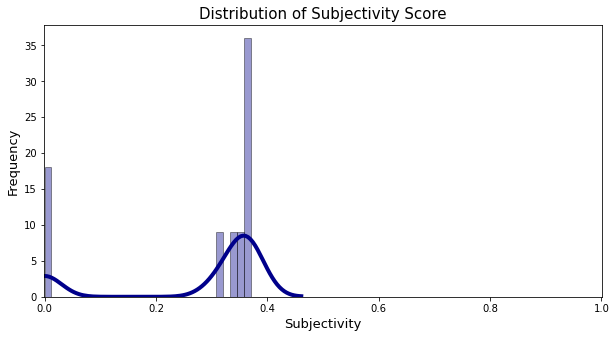

In [67]:
# Density Plot and Histogram of subjectivity
plt.figure(figsize = (10,5))
sns.distplot(dfna['subjectivity'], hist=True, kde=True, 
             bins=int(30), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlim([-0.001,1.001])
plt.xlabel('Subjectivity', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of Subjectivity Score', fontsize=15)

In [53]:
# make a list
listIR = dfna['text'].to_list()

# Create a list of subjectivity score for each year
subjectivityIR = []
for p in listIR:
    subjectivityIR.append(TextBlob(p).sentiment.subjectivity) 

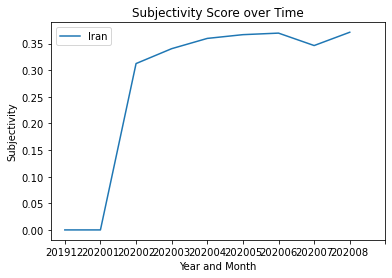

In [64]:
f, ax = plt.subplots()

ax.plot(subjectivityIR, label='Iran')

# Change x ticks to years
xl = list(range(0, 10)) 
ax.set_xticks(xl)
ax.set_xticklabels(yearMonths)

# Add labels
plt.title('Subjectivity Score over Time')
plt.xlabel('Year and Month')
plt.ylabel('Subjectivity')
plt.legend()
plt.show()

### Examining Polarity

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.

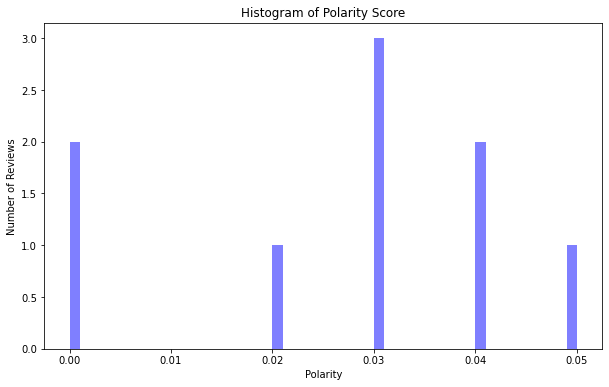

In [66]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(dfna.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

Text(0.5, 1.0, 'Distribution of Polarity Score')

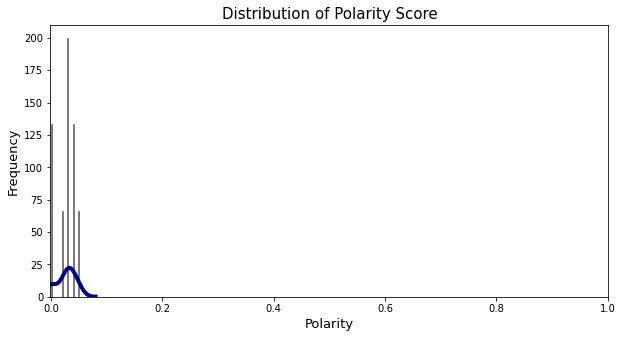

In [68]:
# Density Plot and Histogram of subjectivity
plt.figure(figsize = (10,5))
sns.distplot(dfna['polarity'], hist=True, kde=True, 
             bins=int(30), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlim([-0.001,1.001])
plt.xlabel('Polarity', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of Polarity Score', fontsize=15)

In [62]:
polarityIR = []
for p in listIR:
    polarityIR.append(TextBlob(p).sentiment.polarity) 

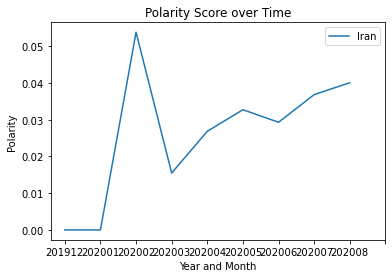

In [65]:
f, ax = plt.subplots()

ax.plot(polarityIR, label='Iran')

# Change x ticks to years
xl = list(range(0, 10)) 
ax.set_xticks(xl)
ax.set_xticklabels(yearMonths)

# Add labels
plt.title('Polarity Score over Time')
plt.xlabel('Year and Month')
plt.ylabel('Polarity')
plt.legend()
plt.show()